In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from tqdm import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.callbacks import EarlyStopping

warnings.simplefilter("ignore")

%matplotlib inline


# Exercícios de Fixação de Conceitos (EFC) 3 – 2s2020

## Parte 1 – Classificação binária com redes MLP

O problema é de classificação de pessoas como tendo diabetes ou não baseando-se em algumas características, como idade, pressão sanguínea, BMI, etc.

In [2]:
SEED = 100
tf.random.set_seed(SEED)
np.random.seed(SEED)

A tabela abaixo mostra algumas estatísticas das features. Neste dataset existem pessoas de 21 à 81 anos, de pessoas que tiveram até 17 gravidezes, e com um intervalo variado de BMI.

In [3]:
dataframe = pd.read_csv("dados_diabetes.csv")
print(dataframe.columns)
dataframe.describe()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,29.089844,141.753906,32.434635,33.240885,0.348958
std,3.369578,30.464161,12.106039,8.890820,89.100847,6.880498,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.500000,27.500000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,81.000000,1.000000


# Análise das features

Como pode-se ver nos histogramas a seguir, quase todas as features tem distribuição normal ou uma distribuição semelhante à distribuição de poisson (como o número de gravidezes e a idade). Nota-se que a feature "DiabetesPedigreeFunction" não aparece aqui, isto acontece porque ela está em um formato diferente das demais features.

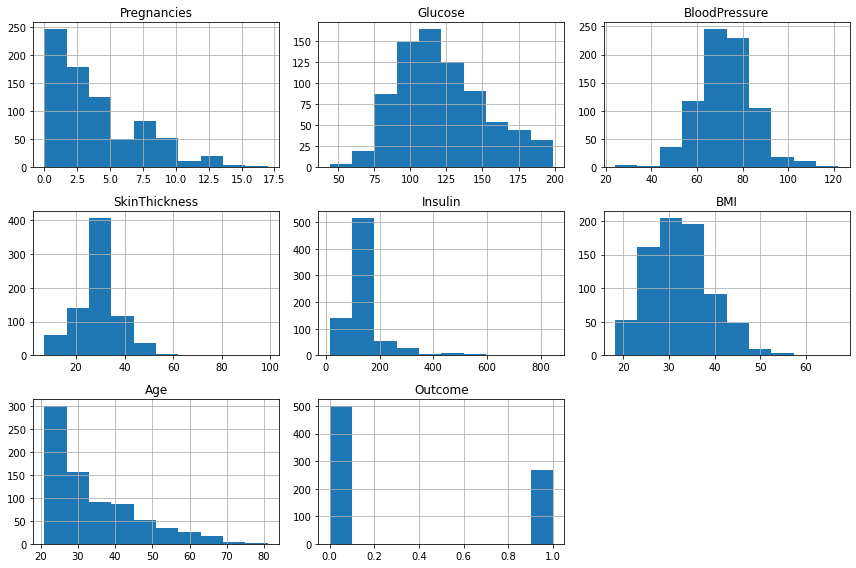

In [4]:
plt.figure(figsize=(12, 8))
dataframe.hist(bins=10, ax=plt.gca());
plt.tight_layout()

Pode-se verificar se a feature de DiabetesPedigreeFunction é categórica:

In [5]:
dataframe.DiabetesPedigreeFunction.nunique()

517

Conclui-se que ela não é, pois existem valores únicos demais para que ela possa ser considerada categórica nesta situação. Desta maneira ela será transformada no número que representa.

Transformando a feature "DiabetesPedigreeFunction" em valores continuos, obtemos o seguinte histograma: 

<AxesSubplot:>

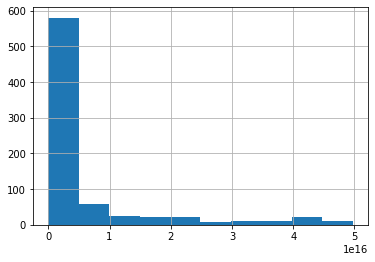

In [6]:
dataframe.DiabetesPedigreeFunction = dataframe.DiabetesPedigreeFunction.apply(lambda x: x.replace(".", "")).apply(float)
dataframe.DiabetesPedigreeFunction.hist(bins=10)

No histograma viu-se que o atributo "Outcome" não está balanceado. Na verdade este dado é a variável que iremos querer predizer através de todos os outros atributos. A distribuição das classes é:

In [7]:
classes, counts = np.unique(dataframe.Outcome, return_counts=True)
for c, i in zip(classes, counts):
    print(f"Class {c}: {i} samples")
print("Proporção da classe 1: {:.2f}%".format(dataframe.Outcome.mean() * 100))

Class 0: 500 samples
Class 1: 268 samples
Proporção da classe 1: 34.90%


Portanto, essas são todas as colunas do arquivo:

In [8]:
for i, c in enumerate(dataframe.columns):
    print("Column {}: {}".format(i, c))

Column 0: Pregnancies
Column 1: Glucose
Column 2: BloodPressure
Column 3: SkinThickness
Column 4: Insulin
Column 5: BMI
Column 6: DiabetesPedigreeFunction
Column 7: Age
Column 8: Outcome


Cada coluna será normalizada de maneira diferente. A coluna "Pregnancies" e "Age" seram normalizada por `min max`, pois como essas colunas não tem outlliers (tem valores bem definidos) e não tem distribuição normal, parece ser a escolha mais adequada. As colunas que tem distribuição similar a normal serão normalizadas por média e distãncia inter-quantil (nos percentis 10% e 90%), para evitar o efeito de dados espúrios. A coluna DiabetesPedigreeFunction será normalizada por transformação de histograma, já que a distribuição dessa feature é um pouco diferente de uma distribuição mais convencional.

Também aqui já será dividido o dataset de holdout, que servirá de validação. Serão utilizados 25% dos dados para validação.

In [9]:

preprocessor = ColumnTransformer(
    [
        ("min_max_1", MinMaxScaler(feature_range=(0, 1)), [0]),
        ("robust_scaler_1", RobustScaler(quantile_range=(10.0, 90.0)), [1]),
        ("robust_scaler_2", RobustScaler(quantile_range=(10.0, 90.0)), [2]),
        ("robust_scaler_3", RobustScaler(quantile_range=(10.0, 90.0)), [3]),
        ("robust_scaler_4", RobustScaler(quantile_range=(10.0, 90.0)), [4]),
        ("robust_scaler_5", RobustScaler(quantile_range=(10.0, 90.0)), [5]),
        ("quantile_transform", QuantileTransformer(n_quantiles=50, output_distribution='uniform'), [6]),
        ("min_max_2", MinMaxScaler(feature_range=(-1, 1)), [7]),
    ]
)

features = dataframe.iloc[:, :-1].values
labels = dataframe.iloc[:, [8]].values
x_trainval, x_test, y_trainval, y_test = train_test_split(features, labels, test_size=0.25, stratify=labels)


Após a transformação, as distribuições são:

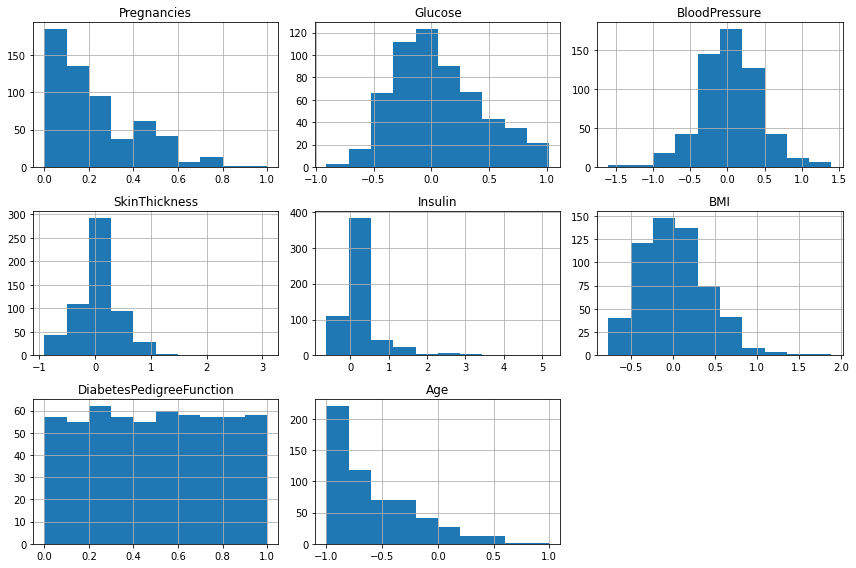

In [10]:
features_n = preprocessor.fit_transform(x_trainval)
plt.figure(figsize=(12, 8))
pd.DataFrame(features_n, columns=dataframe.columns[:-1]).hist(bins=10, ax=plt.gca());
plt.tight_layout()

## Treinamento

Neste passo várias MLP's de uma camada escondida serão treinadas, utilizando o protocolo de validação cruzada, para se encontrar o melhor número de neurônios da camada escondida. A validação cruzada será feita utilizando 10 folds. Desta maneira pode-se achar o melhor número de neurônios para este problema, para posteriormente treinar o modelo final.

Serão treinadas 100 redes com 2, 4, 6, ..., 200 neurônios na camada escondida. Após os treinamentos, a rede com melhor acurácia balanceada na validação cruzada (utilizando apenas dados de treino) será escolhida, e será retreinada em todos dados de treino.

As redes serão treinadas utilizando o otimizar Adam, e o `alpha` (que é o parametro de regularização l2 para esta classe do sklearn) será setado para zero, assim cada modelo poderá se ajustar sem restrições para que se possa ver com mais clareza o efeito do aumento do número de neurônios.

In [11]:
METRICS = [f1_score, precision_score, recall_score, balanced_accuracy_score]

def evaluate(y_target, y_pred, metrics=METRICS):
    results = {}
    for metric in metrics:
        name = metric.__name__
        results[name] = metric(y_target, y_pred)
    return results

def train_model(model_fn, kwargs, X, Y, metrics=METRICS, n_folds=10):
    """ Train the model generated by `model_fn` using a cross validation protocol.
    Returns metrics calculated for each fold, for the train and validation sets.
    """
    model = model_fn(** kwargs)
    skf = StratifiedKFold(n_splits=n_folds, random_state=SEED)
    
    train_results = {metric.__name__: [] for metric in metrics}
    val_results = {metric.__name__: [] for metric in metrics}
    for train_idx, val_idx in skf.split(X, Y):
        train_features, train_labels = X[train_idx], Y[train_idx]
        val_features, val_labels = X[val_idx], Y[val_idx]
        
        train_features = preprocessor.fit_transform(train_features)
        val_features = preprocessor.transform(val_features)
        
        model.fit(train_features, train_labels)
        train_pred = model.predict(train_features)
        val_pred = model.predict(val_features)
        
        for metric in metrics:
            name = metric.__name__
            train_results[name].append(
                metric(train_labels, train_pred)
            )
            val_results[name].append(
                metric(val_labels, val_pred)
            )
    return train_results, val_results

train_results, val_results = [], []
n_neurons_arr = list(range(2, 201, 2))

"""
For each number of neurons, train a model using a 5-fold cross validation, 
and stores the mean balanced accuracy score in the 5 folds.
"""
for n_neurons in tqdm(n_neurons_arr):
    train_res, val_res = train_model(
        MLPClassifier,
        {
            "hidden_layer_sizes": n_neurons,
            "learning_rate_init": 0.001,
            "max_iter": 5000,
            "random_state": SEED,
            "early_stopping": True,
            "n_iter_no_change": 20,
            "tol": 1e-3,
            "alpha": 0
        },
        x_trainval,
        y_trainval
    )
    train_results.append(
        np.mean(train_res["balanced_accuracy_score"])
    )
    val_results.append(
        np.mean(val_res["balanced_accuracy_score"])
    )

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:43<00:00,  2.23s/it]


Text(0, 0.5, 'Acurácia Balanceada')

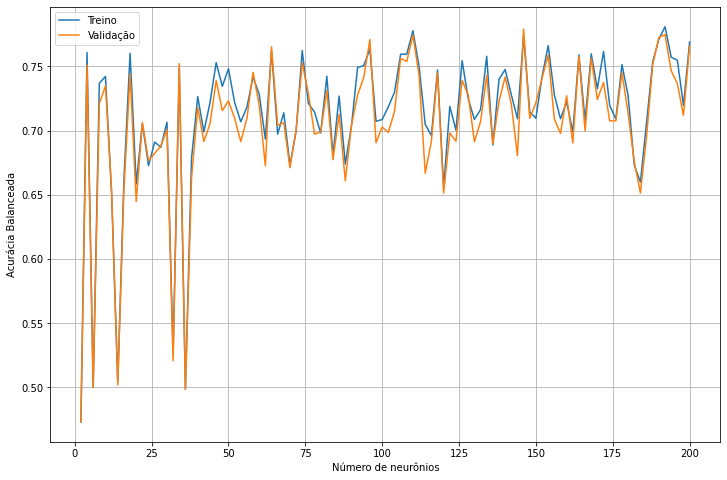

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(n_neurons_arr, train_results, label="Treino")
plt.plot(n_neurons_arr, val_results, label="Validação")
plt.legend()
plt.grid()
plt.xlabel("Número de neurônios")
plt.ylabel("Acurácia Balanceada")


Verifica-se que o modelo tem performance semelhante na validação independente do número de neurônios utilizados aqui. Se for ocorrer overfitting devido ao tamanho do modelo, talvez ele ocorra com um número superior de neurônios.

Encontrando-se o número ótimo de neurônios para o modelo, agora ele pode ser instanciado.

Obs: Aqui será utilizado outra biblioteca para instanciação do modelo pela facilidade que ela dá em retornar os erros de treino e validação. A sua performance não será afetada.

In [13]:
best_n_neurons = n_neurons_arr[np.argmax(val_results)]
print("O Número ótimo de neurônios é", best_n_neurons)
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=8),
        tf.keras.layers.Dense(best_n_neurons),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
    loss="binary_crossentropy",
    loss_weights=None,
    metrics=["accuracy"]
)
model.summary()

O Número ótimo de neurônios é 146
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 146)               1314      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 147       
Total params: 1,461
Trainable params: 1,461
Non-trainable params: 0
_________________________________________________________________


In [14]:
X_train = preprocessor.fit_transform(x_trainval)
Y_train = y_trainval
X_val = preprocessor.transform(x_test)
Y_val = y_test

callbacks = EarlyStopping(
    monitor="val_loss",
    patience=20,
    min_delta=1e-3,
    restore_best_weights=True
)

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), callbacks=callbacks, epochs=5000, batch_size=32, verbose=0)

In [15]:
pred = (model.predict(X_val) > 0.5).astype(np.int)

bas = balanced_accuracy_score(Y_val, pred)
acs = accuracy_score(Y_val, pred)
print("Matriz de confusão")
print(confusion_matrix(Y_val, pred))
print()
print("Estatísticas da predição")
print(classification_report(Y_val, pred))

print("Acurácia: {:.2f}%".format(acs * 100))
print("Acurácia balanceada: {:.2f}%".format(bas * 100))


Matriz de confusão
[[108  17]
 [ 27  40]]

Estatísticas da predição
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       125
           1       0.70      0.60      0.65        67

    accuracy                           0.77       192
   macro avg       0.75      0.73      0.74       192
weighted avg       0.77      0.77      0.77       192

Acurácia: 77.08%
Acurácia balanceada: 73.05%


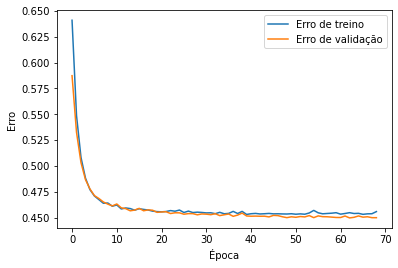

In [16]:
plt.plot(history.history["loss"], label="Erro de treino")
plt.plot(history.history["val_loss"], label="Erro de validação")
plt.xlabel("Época")
plt.ylabel("Erro")
plt.legend()

## Conclusão

Percebe-se que quanto não necessariamente um número grande de neurônios será o melhor para um modelo, devido ao overfitting. Entretanto neste problema ainda não pode-se verificar o efeito do overfitting completamente, já que no espaço de busca que se utilizou para os neurônios o melhor valor encontrado foi alto. Também pode-se utilizar na prática o protocolo de validação cruzada para se encontrar os melhores hiperparâmetros deste modelo (neste caso, o número de neurônios), verificando-se assim este método de otimização de parâmetros.